In [72]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [18]:
# Load the MATLAB .mat file
mat_data = scipy.io.loadmat('Data/iris_data.mat')

# Extract the variables
iris_data = mat_data['iris_data']
iris_type = mat_data['iris_type'].flatten()  # Convert from 2D array to 1D
print("iris_data shape:", iris_data.shape)
print("iris_type shape:", iris_type.shape)

df = pd.DataFrame(iris_data, columns=["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"])
df['Type'] = iris_type
df['Type'] = df['Type'] - 1
df.to_csv("Data/iris_data.csv", index=False)

iris_data shape: (100, 4)
iris_type shape: (100,)


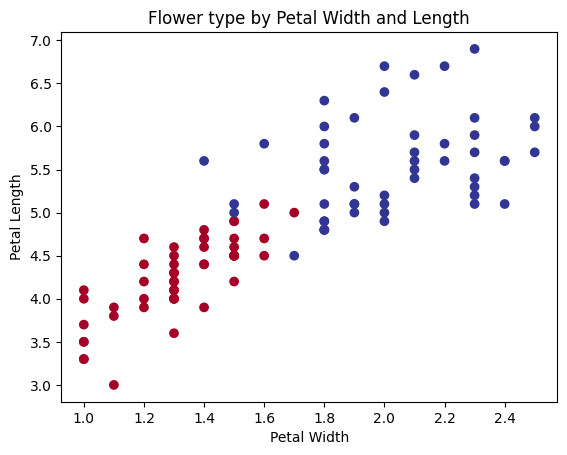

In [4]:
# Read data and examine it
data = pd.read_csv("Data/iris_data.csv", )
data = data[['Petal Length', 'Petal Width', 'Type']]

# ax = data.loc[data['Type']==0].plot(x='Petal Length', y='Petal Width', style='o', label='Type 0')
# data.loc[data['Type']==1].plot(x='Petal Length', y='Petal Width', style='x', color='red', ax=ax, label='Type 1')
# ax.set_title("Petal Length and Width of 2 different flower types")
# ax.legend(loc='upper left')
# plt.show()

plt.scatter(x=data['Petal Width'], y=data['Petal Length'], c=data['Type'], cmap=plt.cm.RdYlBu)
plt.title('Flower type by Petal Width and Length')
plt.xlabel('Petal Width')
plt.ylabel('Petal Length')
plt.show()

In [32]:
data.loc[(data['Petal Width']==1.8) & (data['Petal Length']==4.8)] # Impossible perfect decision boundary

,Petal Length,Petal Width,Type
20,4.8,1.8,0
76,4.8,1.8,1
88,4.8,1.8,1


In [61]:
# Now to prep data for PyTorch
X = np.array(data[['Petal Width', 'Petal Length']])
y = np.array(data['Type'])
y = y.reshape(-1, 1)
X.shape, y.shape

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

# Split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) # Check sizes


torch.Size([99, 2]) torch.Size([99, 1]) torch.Size([1, 2]) torch.Size([1, 1])


In [ ]:
# Setup PyTorch model
device ="cuda" if torch.cuda.is_available() else "cpu"

class FlowerClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x # Output raw logit for use with BCEWithLogitsLoss loss function
    
model_0 = FlowerClassifier()    

untrained_preds = model_0(X_test.to(device))
# print(untrained_preds[:10], torch.sigmoid(untrained_preds[:10]), y[:10]) # complete garbage

# Setup loss and optimizer
lr = 0.01 # Learning rate
loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.SGD(model_0.parameters(), lr=lr)

# Train model
torch.manual_seed(42)
epochs = 10000

# Put data onto target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

    # 1. Forward pass - calculate output of model
    y_logits = model_0(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_logits, y_train)

    # Optimiser zero grad
    optimiser.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimiser step
    optimiser.step()

    if (epoch+1)%100 == 0:
        # Output loss every 100 iterations just to see how it's getting on
        print(f"Epoch [{epoch+1}/{epochs}], Loss:{loss.item():.4f}")

# Evaluate
model_0.eval()
with torch.no_grad():
    # Get raw logits for test set
    y_test_logit = model_0(X_test.float().to(device))
    
    # Apply sigmoid to get probabilities
    y_test_prob = torch.sigmoid(y_test_logit)
    # Clas prediction: prob>0.5 => class 1
    y_test_pred = (y_test_prob >= 0.5).long()

Epoch [100/10000], Loss:0.6708
Epoch [200/10000], Loss:0.6604
Epoch [300/10000], Loss:0.6486
Epoch [400/10000], Loss:0.6350
Epoch [500/10000], Loss:0.6191
Epoch [600/10000], Loss:0.6002
Epoch [700/10000], Loss:0.5777
Epoch [800/10000], Loss:0.5511
Epoch [900/10000], Loss:0.5200
Epoch [1000/10000], Loss:0.4850
Epoch [1100/10000], Loss:0.4478
Epoch [1200/10000], Loss:0.4103
Epoch [1300/10000], Loss:0.3741
Epoch [1400/10000], Loss:0.3407
Epoch [1500/10000], Loss:0.3111
Epoch [1600/10000], Loss:0.2857
Epoch [1700/10000], Loss:0.2642
Epoch [1800/10000], Loss:0.2460
Epoch [1900/10000], Loss:0.2304
Epoch [2000/10000], Loss:0.2171
Epoch [2100/10000], Loss:0.2057
Epoch [2200/10000], Loss:0.1958
Epoch [2300/10000], Loss:0.1872
Epoch [2400/10000], Loss:0.1795
Epoch [2500/10000], Loss:0.1728
Epoch [2600/10000], Loss:0.1667
Epoch [2700/10000], Loss:0.1612
Epoch [2800/10000], Loss:0.1563
Epoch [2900/10000], Loss:0.1518
Epoch [3000/10000], Loss:0.1477
Epoch [3100/10000], Loss:0.1439
Epoch [3200/10000

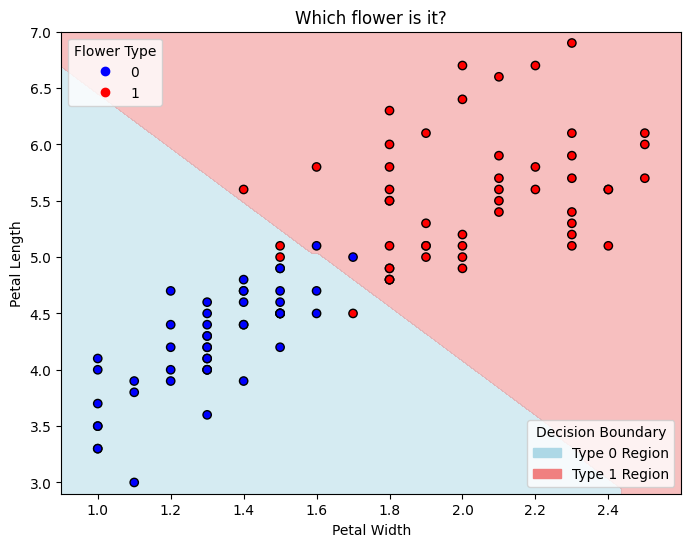

In [80]:
# Plot decision boundary

# 1. Create meshgrid
x1_min, x1_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
x2_min, x2_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                     np.linspace(x2_min, x2_max, 100))


# 2. Flatten grid, pass x1, x2 coords to model and obtain predictions at each point
X_grid = np.column_stack((xx.ravel(), yy.ravel()))


model_0.eval()
with torch.no_grad():
    X_grid_t = torch.from_numpy(X_grid).float().to(device)
    y_logits = model_0(X_grid_t)
    y_prob = torch.sigmoid(y_logits)
    y_pred = (y_prob >= 0.5).long()

# 3. Plot the contour of the predictions
cmap_custom = ListedColormap(['lightblue', 'lightcoral'])  # Class 0 = blue, Class 1 = red
scatter_cmap = ListedColormap(['blue', 'red'])  # Points get darker shades
Z = y_pred.reshape(xx.shape)
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, levels=[-0.5, 0.5, 1.5], alpha=0.5, cmap=cmap_custom)
scatter = plt.scatter(data['Petal Width'], data['Petal Length'], c=data['Type'], cmap=scatter_cmap, edgecolors='k')
plt.xlabel("Petal Width")
plt.ylabel("Petal Length")
plt.title("Which flower is it?")


#Flower type legend
scatter_legend = plt.legend(*scatter.legend_elements(), title="Flower Type", loc="upper left")
# Decision boundary legend
decision_boundary_legend = [
    mpatches.Patch(color='lightblue', label='Type 0 Region'),
    mpatches.Patch(color='lightcoral', label='Type 1 Region')
]
plt.legend(handles=decision_boundary_legend, title="Decision Boundary", loc="lower right")
plt.gca().add_artist(scatter_legend)

plt.show()



In [87]:
# Setup PyTorch model
device ="cuda" if torch.cuda.is_available() else "cpu"

class FlowerClassifier_v2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=20)
        self.layer_2 = nn.Linear(in_features=20, out_features=20)
        self.layer_3 = nn.Linear(in_features=20, out_features=10)
        self.layer_4 = nn.Linear(in_features=10, out_features=1)


    def forward(self, x):
        x = F.leaky_relu(self.layer_1(x))
        x = F.tanh(self.layer_2(x))
        x = F.relu(self.layer_3(x))
        x = self.layer_4(x)  # Output raw logits
        return x # Output raw logit for use with BCEWithLogitsLoss loss function
    
model_1 = FlowerClassifier_v2()    

# Setup loss and optimizer
lr = 0.01 # Learning rate
loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.SGD(model_1.parameters(), lr=lr)

# Train model
torch.manual_seed(42)
epochs = 200000

# Put data onto target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

    # 1. Forward pass - calculate output of model
    y_logits = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_logits, y_train)

    # Optimiser zero grad
    optimiser.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimiser step
    optimiser.step()

    if (epoch+1)%100 == 0:
        # Output loss every 100 iterations just to see how it's getting on
        print(f"Epoch [{epoch+1}/{epochs}], Loss:{loss.item():.4f}")

# Evaluate
model_1.eval()
with torch.no_grad():
    # Get raw logits for test set
    y_test_logit = model_1(X_test.float().to(device))
    
    # Apply sigmoid to get probabilities
    y_test_prob = torch.sigmoid(y_test_logit)
    # Clas prediction: prob>0.5 => class 1
    y_test_pred = (y_test_prob >= 0.5).long()
    
    

    

Epoch [100/200000], Loss:0.6897
Epoch [200/200000], Loss:0.6821
Epoch [300/200000], Loss:0.6758
Epoch [400/200000], Loss:0.6690
Epoch [500/200000], Loss:0.6613
Epoch [600/200000], Loss:0.6521
Epoch [700/200000], Loss:0.6410
Epoch [800/200000], Loss:0.6274
Epoch [900/200000], Loss:0.6102
Epoch [1000/200000], Loss:0.5889
Epoch [1100/200000], Loss:0.5644
Epoch [1200/200000], Loss:0.5355
Epoch [1300/200000], Loss:0.5023
Epoch [1400/200000], Loss:0.4676
Epoch [1500/200000], Loss:0.4319
Epoch [1600/200000], Loss:0.4002
Epoch [1700/200000], Loss:0.3729
Epoch [1800/200000], Loss:0.3486
Epoch [1900/200000], Loss:0.3260
Epoch [2000/200000], Loss:0.3055
Epoch [2100/200000], Loss:0.2872
Epoch [2200/200000], Loss:0.2718
Epoch [2300/200000], Loss:0.2578
Epoch [2400/200000], Loss:0.2450
Epoch [2500/200000], Loss:0.2335
Epoch [2600/200000], Loss:0.2230
Epoch [2700/200000], Loss:0.2136
Epoch [2800/200000], Loss:0.2050
Epoch [2900/200000], Loss:0.1972
Epoch [3000/200000], Loss:0.1901
Epoch [3100/200000]

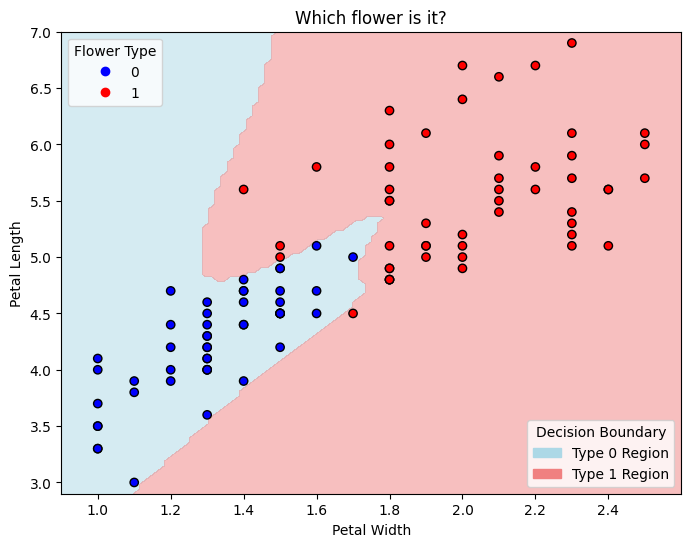

In [88]:
# Plot decision boundary

# 1. Create meshgrid
x1_min, x1_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
x2_min, x2_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                     np.linspace(x2_min, x2_max, 100))


# 2. Flatten grid, pass x1, x2 coords to model and obtain predictions at each point
X_grid = np.column_stack((xx.ravel(), yy.ravel()))


model_1.eval()
with torch.no_grad():
    X_grid_t = torch.from_numpy(X_grid).float().to(device)
    y_logits = model_1(X_grid_t)
    y_prob = torch.sigmoid(y_logits)
    y_pred = (y_prob >= 0.5).long()

# 3. Plot the contour of the predictions
cmap_custom = ListedColormap(['lightblue', 'lightcoral'])  # Class 0 = blue, Class 1 = red
scatter_cmap = ListedColormap(['blue', 'red'])  # Points get darker shades
Z = y_pred.reshape(xx.shape)
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, levels=[-0.5, 0.5, 1.5], alpha=0.5, cmap=cmap_custom)
scatter = plt.scatter(data['Petal Width'], data['Petal Length'], c=data['Type'], cmap=scatter_cmap, edgecolors='k')
plt.xlabel("Petal Width")
plt.ylabel("Petal Length")
plt.title("Which flower is it?")


#Flower type legend
scatter_legend = plt.legend(*scatter.legend_elements(), title="Flower Type", loc="upper left")
# Decision boundary legend
decision_boundary_legend = [
    mpatches.Patch(color='lightblue', label='Type 0 Region'),
    mpatches.Patch(color='lightcoral', label='Type 1 Region')
]
plt.legend(handles=decision_boundary_legend, title="Decision Boundary", loc="lower right")
plt.gca().add_artist(scatter_legend)

plt.show()



In [56]:
data.min()

Petal Length    3.0
Petal Width     1.0
Type            0.0
dtype: float64